### Table of Contents

* [Data preparation](#data-preparation)
* [Helper methods](#Helper-methods)
* [Model training](#Model-training)
* [Model evaluation](#Model-evaluation)
* [Feature importance](#Feature-importance)
* [Notes](#Notes)


### Data preparation

In [2]:
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('df-merged-v2.csv')
df.head()

,bst_nr_8,country,prod_date,num_trips,delay_minutes,dayofweek,weekofyear,month,latitude,longitude,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,bundesland,regierungsbezirk,landkreis
0,80197079,DEUTSCHLAND,2016-03-16,39,49,3,11,3,49.42045,7.613668,...,0.0,0.0,49.5,21.2,NaN,1024.5,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
1,80197079,DEUTSCHLAND,2016-10-11,38,74,2,41,10,49.42045,7.613668,...,0.0,0.0,NaN,3.4,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
2,80197079,DEUTSCHLAND,2016-08-29,27,33,1,35,8,49.42045,7.613668,...,0.0,0.0,NaN,6.9,NaN,1018.8,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
3,80197079,DEUTSCHLAND,2016-02-25,53,85,4,8,2,49.42045,7.613668,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern
4,80197079,DEUTSCHLAND,2016-05-28,39,38,6,21,5,49.42045,7.613668,...,13.8,0.0,NaN,NaN,NaN,NaN,NaN,Rheinland-Pfalz,Rheinhessen-Pfalz,Kaiserslautern


In [5]:
df.columns

Index(['bst_nr_8', 'country', 'prod_date', 'num_trips', 'delay_minutes',
       'dayofweek', 'weekofyear', 'month', 'latitude', 'longitude', 'day',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'bundesland', 'regierungsbezirk', 'landkreis'],
      dtype='object')

In [6]:
excluded_columns = ['bst_nr_8', 'prod_date', 'country', 'month', 'day', 'bundesland', 'regierungsbezirk']
df = df[df.columns.difference(excluded_columns)]

### Helper methods

In [25]:
def create_train_test_dataset(dataset, target_column, test_size=0.2):
    """
    Creates train and test datasets
    
    :param dataset: Pandas DataFrame
    :param target_column: str
    :param test_size:
    :return: X_train, X_test, y_train, y_test
    """
    feature_names = dataset.columns.difference([TARGET])
    X = dataset[feature_names]
    y = dataset[[TARGET]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test


def run_autogluon_experiment(dataset,
                             target_column,
                             problem_type,
                             eval_metric,
                             time_limit=600):
    """
    Fits training dataset on autogluon.TabularPredictor

    :param dataset:
    :param target_column:
    :param problem_type:
    :param eval_metric:
    :param time_limit:
    :return:
    """
    predictor = TabularPredictor(
        label = target_column,
        problem_type = problem_type,
        eval_metric = eval_metric,
        # learner_kwargs = {'ignored_columns': ['BST_NR_8', 'Land', 'PROD_DATUM', 'dayofweek']}
    )
    
    # hyperparameters={'RF':{}, 'GBM':{}, 'XT':{}, 'XGB':{}}
    hyperparameters={'GBM':{}, 'XGB':{}}
    
    predictor.fit(
        train_data = dataset,
        time_limit = time_limit,
        hyperparameters = hyperparameters, 
        presets='high_quality_fast_inference_only_refit',
    )
    
    return predictor

### Model training

In [ ]:
TEST_SIZE = 0.2
TIME_LIMIT = 900

TARGET = 'delay_minutes'
PROBLEM_TYPE = 'regression'
EVAL_METRIC = 'root_mean_squared_error'

X_train, X_test, y_train, y_test = create_train_test_dataset(
    dataset = df, 
    target_column = TARGET,
    test_size=TEST_SIZE
)

train_data = pd.concat([X_train, y_train], axis=1)
    
predictor = run_autogluon_experiment(dataset=train_data,
                                     target_column=TARGET,
                                     problem_type=PROBLEM_TYPE,
                                     eval_metric=EVAL_METRIC,
                                     time_limit=TIME_LIMIT)

### Model evaluation

In [29]:
test_data = pd.concat([X_test, y_test], axis=1)
test_performance = predictor.evaluate(test_data, auxiliary_metrics=False)
test_performance

Evaluation: root_mean_squared_error on test data: -136.7549436086266
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -136.7549436086266
}


{'root_mean_squared_error': -136.7549436086266}

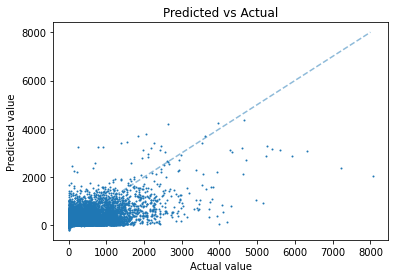

In [31]:
predictions = predictor.predict(test_data)

plt.scatter(test_data['delay_minutes'], predictions, s=1)

ident = [0.0, 8000.0]
plt.plot(ident,ident, '--', alpha=0.5)

plt.title('Predicted vs Actual')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

### Feature importance

In [32]:
# feature importance on training dataset

predictor.feature_importance(data=train_data)

Computing feature importance via permutation shuffling for 16 features using 1000 rows with 3 shuffle sets...
	17.41s	= Expected runtime (5.8s per shuffle set)
	5.39s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
landkreis,74.234648,22.998536,0.015268,3,206.018810,-57.549515
num_trips,65.564273,23.252153,0.019730,3,198.801687,-67.673142
latitude,31.527821,11.354849,0.020310,3,96.592365,-33.536724
longitude,26.957436,8.644492,0.016305,3,76.491333,-22.576460
weekofyear,13.942351,13.116072,0.103473,3,89.098898,-61.214196
wspd,6.008745,4.574853,0.075363,3,32.223161,-20.205672
prcp,5.178886,8.430379,0.199393,3,53.485893,-43.128120
wdir,4.283831,2.123214,0.036514,3,16.450082,-7.882420
tsun,4.040005,4.497949,0.130022,3,29.813750,-21.733741
wpgt,3.873162,2.708207,0.065782,3,19.391489,-11.645166


In [33]:
# feature importance on test dataset 

predictor.feature_importance(data=test_data)

Computing feature importance via permutation shuffling for 16 features using 1000 rows with 3 shuffle sets...
	16.61s	= Expected runtime (5.54s per shuffle set)
	5.09s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
landkreis,65.847722,12.325848,0.005739,3,136.476196,-4.780753
num_trips,44.782165,13.977006,0.015485,3,124.871957,-35.307628
latitude,40.221614,16.257553,0.025190,3,133.379196,-52.935967
longitude,28.642452,11.009454,0.022943,3,91.727845,-34.442942
pres,3.305136,0.727484,0.007884,3,7.473702,-0.863430
weekofyear,2.775730,2.902172,0.119724,3,19.405499,-13.854038
tavg,1.314510,2.815122,0.251780,3,17.445472,-14.816451
wpgt,1.168863,4.183859,0.338132,3,25.142837,-22.805110
tsun,0.483988,3.572522,0.418158,3,20.954936,-19.986960
wspd,0.450700,0.880241,0.234364,3,5.494576,-4.593177


### Notes

---------------------------------

Time limit: 10 Minutes

Dataset: db-cargo-delays-2016-deutschland.csv

Features: Zugfahrten, Verspaetungsminuten, weekofyear

RMSE: 177.84

Updated on: 06.01.2022 

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Features: ['bst_nr_8', 'day', 'dayofweek', 'delay_minutes', 'latitude', 'longitude', 
            'month', 'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun', 
            'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 134.25

Updated on: 08.01.2022 

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Month: 1

Features: ['bst_nr_8', 'day', 'dayofweek', 'delay_minutes', 'latitude', 'longitude', 
            'month', 'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun', 
            'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 147.47

Updated on: 08.01.2022 

---------------------------------

Time limit: 10 Minutes

Dataset: df-merged-v2.csv

Month: 1

Features: ['dayofweek', 'delay_minutes', 'landkreis', 'latitude', 'longitude', 
       'num_trips', 'prcp', 'pres', 'snow', 'tavg', 'tmax', 'tmin', 'tsun',
       'wdir', 'weekofyear', 'wpgt', 'wspd']

Presets: 'high_quality_fast_inference_only_refit',

RMSE: 136.79

Updated on: 09.01.2022 

---------------------------------